# Tabular GANs performance study (Experiment 2)

This notebook contains the code to reproduce the performance study of CTGAN.

In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import re
#from sdv.tabular import CopulaGAN, CTGAN,TVAE
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, ConfusionMatrixDisplay

In [2]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [3]:
df_alleles = pd.read_csv('oncoth1_with_n_risk_alleles.csv')

In [4]:
df = pd.read_csv('development_db_score_oncothromb.csv')

In [5]:
df_alleles['VTE'] = df['VTE'].values

# Apply paper preprocess pipeline

In [6]:
gen_predictors = ['rs4524', 'rs6025', 'rs2232698', 'rs2227631', 'rs268', 'rs169713', 'rs11696364', 'rs5110','rs6003']

In [7]:
#Select the risk alleles of the selected features
alleles_ = []
for element in gen_predictors:
    alleles_.append(element + '_n_risk_alleles')
alleles_.append('VTE')
alleles_.append('id')
df_alleles = df_alleles[alleles_].dropna()

### Compute Genetic Risk Score

In [8]:
from sklearn.linear_model import LogisticRegression

y = df_alleles['VTE']
X = df_alleles.drop(columns=['VTE', 'id'])

model = LogisticRegression(fit_intercept = True)
model.fit(X, y)

GRS = (model.coef_ * X).sum(axis=1) + model.intercept_
df_alleles['GRS'] = GRS

## Clinical Variables

- very high risk -> stomach, pancreas
- high risk -> lung, lymphoma, gynelocoligal, blader, testicular
- low risk -> colorectal
- platelet count >= 350x10^9/L -> high risk
- leukocyte count >= 11x10^9/L -> high risk

In [9]:
import re
def map_column(row, clinical_dict):
    row = str(row)
    for key, value in clinical_dict.items():
        if re.match(value[0], row):
            return key
    return 'No Clasificado'

In [10]:
def preprocess_clinical_features(df):
    df_clin = df.iloc[:, 1:21]
    cols_names_clin = df_clin.columns[1:]

    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Colorectal', 'primary_tumor_simplified'] = 0
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'NSCLC', 'primary_tumor_simplified'] = 1
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Oesophago-gastric', 'primary_tumor_simplified'] = 2
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Pancreatic', 'primary_tumor_simplified'] = 2

    df_clin.loc[df_clin['leukocytes'] < 11000, 'leukocytes'] = 0
    df_clin.loc[df_clin['leukocytes'] >= 11000, 'leukocytes'] = 1
    df_clin.loc[df_clin['platelets'] < 350000, 'platelets'] = 0
    df_clin.loc[df_clin['platelets'] >= 350000, 'platelets'] = 1

    bmi_risk = {
        1: [r"(Obese: BMI > 30 kg/m2)|( Overweight: BMI ~25-29.9 Kg/m2)"],
        0: [r"(Normal: BMI ~ 18.5-24.9 Kg/m2)|(Underweight: BMI < 18.5 Kg/m2)"],
    }

    tnm_stage_detailed_risk = {
        1: [r"(IA)|(IB)"],
        2: [r"(IIB)|(IIA)|(IIC)"],
        3: [r"(III)|(IIIB)|(IIIA)|(IIIC)"],
        4: [r"(IVB)|(IVA)|(IV)"],
    }


    df_clin['bmi_category'] = df_clin['bmi_category'].apply(lambda x: map_column(x, bmi_risk))
    df_clin['tnm_stage_detailed'] = df_clin['tnm_stage_detailed'].apply(lambda x: map_column(x, tnm_stage_detailed_risk))

    return df_clin

In [11]:
df_clin = preprocess_clinical_features(df)

### Get the clinical variables following the paper (without p-value selection )

In [12]:
# Drop the variables that are not mentioned in the paper
df_clin = df_clin.drop(['pregnancy', 'oral_contraceptives', 'hemoglobin'], axis=1)
df_clin['id'] = df['id'].values

Select the predictors of the paper

In [13]:
clin_predictors = ['tnm_stage_detailed', 'bmi_category', 'primary_tumor_simplified', 'id', 'VTE']
df_clin = df_clin[clin_predictors]
pred = ['id', 'GRS', 'VTE']
predictors = df_alleles[pred]
df_ft = predictors.merge(df_clin, on=['id','VTE'])
df = df_ft.drop(['id'],axis=1)
df['primary_tumor_simplified'] = df['primary_tumor_simplified'].astype(int)

In [14]:
df.head()

,GRS,VTE,tnm_stage_detailed,bmi_category,primary_tumor_simplified
0,-0.309952,1,4,1,2
1,-1.015882,0,2,0,2
2,-0.994715,0,3,1,2
3,-2.016533,0,2,0,2
4,-1.283673,0,1,0,2


Dataset with duplicates

In [15]:
X_real_dupes = df.drop('VTE', axis=1)
y_real_dupes = df['VTE']

Dataset with no duplicates

In [16]:
df_no_dupes = df.drop_duplicates()
X_real_no_dupes = df_no_dupes.drop('VTE', axis=1)
y_real_no_dupes = df_no_dupes['VTE']

# Generate Data

In [17]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_no_dupes)

C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


In [18]:
metadata_dict = metadata.to_dict()
metadata_obj = SingleTableMetadata.load_from_dict(metadata_dict)

In [19]:
metadata.update_column(
    column_name='VTE',
    sdtype='categorical')

metadata.update_column(
    column_name='tnm_stage_detailed',
    sdtype='categorical')

metadata.update_column(
    column_name='bmi_category',
    sdtype='categorical')

metadata.update_column(
    column_name='primary_tumor_simplified',
    sdtype='categorical')

In [ ]:
metadata_dict = metadata.to_dict()
metadata_obj = SingleTableMetadata.load_from_dict(metadata_dict)

CTGAN

In [22]:
synthesizer = CTGANSynthesizer(metadata_obj, epochs=1000, batch_size = 30, discriminator_steps=5, verbose=True)
synthesizer.fit(df_no_dupes)

C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\numerical.py:112: UserWarning: No rounding scheme detected for column 'GRS'. Data will not be rounded.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_

Epoch 1, Loss G:  0.0113,Loss D: -0.2787
Epoch 2, Loss G: -0.1935,Loss D: -0.1630
Epoch 3, Loss G: -0.1854,Loss D: -0.6845
Epoch 4, Loss G: -0.6231,Loss D: -0.2851
Epoch 5, Loss G: -0.0960,Loss D:  0.1531
Epoch 6, Loss G: -0.7134,Loss D: -0.0516
Epoch 7, Loss G: -0.9910,Loss D:  0.2226
Epoch 8, Loss G: -0.2839,Loss D: -0.2182
Epoch 9, Loss G: -0.3901,Loss D: -0.3764
Epoch 10, Loss G: -0.7043,Loss D:  0.1543
Epoch 11, Loss G:  0.1491,Loss D: -0.4119
Epoch 12, Loss G: -0.6801,Loss D:  0.3235
Epoch 13, Loss G: -0.8250,Loss D:  0.2580
Epoch 14, Loss G: -0.2181,Loss D: -0.4870
Epoch 15, Loss G: -0.7781,Loss D: -0.5465
Epoch 16, Loss G: -0.2029,Loss D: -0.1834
Epoch 17, Loss G: -0.0264,Loss D: -0.0147
Epoch 18, Loss G: -0.5427,Loss D:  0.6677
Epoch 19, Loss G: -0.8612,Loss D: -0.3006
Epoch 20, Loss G: -0.2911,Loss D:  0.0962
Epoch 21, Loss G: -1.0348,Loss D: -0.2484
Epoch 22, Loss G:  0.0200,Loss D: -0.2095
Epoch 23, Loss G: -0.5744,Loss D:  0.4668
Epoch 24, Loss G: -0.5450,Loss D:  0.3610
E

Epoch 195, Loss G:  0.2854,Loss D: -1.0222
Epoch 196, Loss G:  0.2987,Loss D: -0.7724
Epoch 197, Loss G:  0.4550,Loss D:  0.4133
Epoch 198, Loss G:  0.1423,Loss D:  0.6308
Epoch 199, Loss G:  0.5682,Loss D: -1.3467
Epoch 200, Loss G:  0.4535,Loss D:  0.5596
Epoch 201, Loss G:  0.2592,Loss D:  0.1934
Epoch 202, Loss G:  0.1243,Loss D: -0.2673
Epoch 203, Loss G:  0.3022,Loss D:  0.3016
Epoch 204, Loss G:  0.6150,Loss D: -0.4318
Epoch 205, Loss G: -0.3834,Loss D: -0.1781
Epoch 206, Loss G: -0.7219,Loss D:  0.2196
Epoch 207, Loss G:  0.1874,Loss D: -0.7556
Epoch 208, Loss G:  0.0743,Loss D: -0.4159
Epoch 209, Loss G: -0.8273,Loss D: -0.0514
Epoch 210, Loss G: -0.4470,Loss D: -0.2396
Epoch 211, Loss G: -0.3994,Loss D:  0.3776
Epoch 212, Loss G: -0.3568,Loss D: -0.4065
Epoch 213, Loss G:  0.1164,Loss D: -0.1479
Epoch 214, Loss G: -0.0535,Loss D: -0.4521
Epoch 215, Loss G:  0.1684,Loss D:  0.4656
Epoch 216, Loss G: -0.3061,Loss D: -0.5075
Epoch 217, Loss G:  0.1853,Loss D: -0.2141
Epoch 218, 

Epoch 386, Loss G: -0.5121,Loss D: -0.0588
Epoch 387, Loss G: -0.7577,Loss D: -0.5368
Epoch 388, Loss G: -0.2291,Loss D:  1.0130
Epoch 389, Loss G:  0.2351,Loss D:  0.7783
Epoch 390, Loss G:  0.3883,Loss D: -0.5882
Epoch 391, Loss G: -0.7982,Loss D:  0.1360
Epoch 392, Loss G: -0.2458,Loss D: -1.0865
Epoch 393, Loss G: -0.6668,Loss D:  1.2741
Epoch 394, Loss G: -0.2370,Loss D: -0.9942
Epoch 395, Loss G: -0.7860,Loss D: -0.4636
Epoch 396, Loss G: -1.0684,Loss D:  0.4788
Epoch 397, Loss G: -0.6584,Loss D: -0.5483
Epoch 398, Loss G: -0.1099,Loss D: -0.4119
Epoch 399, Loss G: -0.5195,Loss D: -1.0595
Epoch 400, Loss G: -0.6391,Loss D: -0.0960
Epoch 401, Loss G: -0.2545,Loss D: -0.2621
Epoch 402, Loss G: -0.0768,Loss D: -0.2861
Epoch 403, Loss G:  0.1024,Loss D:  0.1716
Epoch 404, Loss G:  0.3930,Loss D: -0.0754
Epoch 405, Loss G: -0.0575,Loss D:  0.0707
Epoch 406, Loss G: -1.0683,Loss D: -2.0340
Epoch 407, Loss G: -1.1488,Loss D: -0.8465
Epoch 408, Loss G: -0.5351,Loss D:  0.5741
Epoch 409, 

Epoch 577, Loss G: -0.4355,Loss D:  0.5749
Epoch 578, Loss G: -1.1224,Loss D:  0.0825
Epoch 579, Loss G: -1.0680,Loss D:  0.5192
Epoch 580, Loss G: -0.4556,Loss D: -0.3094
Epoch 581, Loss G: -0.1751,Loss D: -0.7150
Epoch 582, Loss G: -0.8135,Loss D: -1.2547
Epoch 583, Loss G: -0.2098,Loss D:  0.1211
Epoch 584, Loss G: -0.4665,Loss D:  0.1325
Epoch 585, Loss G:  0.0916,Loss D:  0.3101
Epoch 586, Loss G: -0.2421,Loss D: -0.2536
Epoch 587, Loss G:  0.1918,Loss D: -0.2919
Epoch 588, Loss G: -0.3280,Loss D: -0.2792
Epoch 589, Loss G: -0.1400,Loss D:  0.5114
Epoch 590, Loss G: -0.4596,Loss D: -0.1183
Epoch 591, Loss G:  0.0882,Loss D: -0.4007
Epoch 592, Loss G:  0.6488,Loss D: -1.4774
Epoch 593, Loss G:  0.2476,Loss D:  0.2568
Epoch 594, Loss G: -0.8736,Loss D: -1.0299
Epoch 595, Loss G:  0.2208,Loss D: -0.6011
Epoch 596, Loss G: -0.0496,Loss D: -0.2157
Epoch 597, Loss G:  0.0215,Loss D: -0.4766
Epoch 598, Loss G: -0.0386,Loss D: -0.3244
Epoch 599, Loss G:  0.4739,Loss D:  0.4925
Epoch 600, 

Epoch 768, Loss G: -1.2343,Loss D: -2.0791
Epoch 769, Loss G: -0.7273,Loss D: -1.0732
Epoch 770, Loss G: -1.1026,Loss D: -0.0129
Epoch 771, Loss G: -0.2181,Loss D: -0.0816
Epoch 772, Loss G: -0.8983,Loss D: -1.4241
Epoch 773, Loss G: -0.6976,Loss D: -0.5159
Epoch 774, Loss G:  0.0483,Loss D: -0.3521
Epoch 775, Loss G: -0.7530,Loss D: -0.0709
Epoch 776, Loss G: -1.1353,Loss D: -0.3399
Epoch 777, Loss G: -0.5953,Loss D:  0.1016
Epoch 778, Loss G: -0.6871,Loss D: -1.5136
Epoch 779, Loss G: -1.4813,Loss D: -0.8480
Epoch 780, Loss G: -0.7563,Loss D:  0.2798
Epoch 781, Loss G: -0.7153,Loss D: -1.5302
Epoch 782, Loss G: -0.4796,Loss D: -1.5753
Epoch 783, Loss G: -0.7331,Loss D: -0.3604
Epoch 784, Loss G: -0.8931,Loss D: -0.0305
Epoch 785, Loss G: -1.4065,Loss D: -0.9080
Epoch 786, Loss G: -0.5572,Loss D: -0.6350
Epoch 787, Loss G:  1.0920,Loss D: -0.1238
Epoch 788, Loss G: -1.0828,Loss D: -0.1834
Epoch 789, Loss G: -0.5797,Loss D:  1.3282
Epoch 790, Loss G: -0.0223,Loss D: -1.1577
Epoch 791, 

Epoch 959, Loss G: -1.1002,Loss D:  0.0343
Epoch 960, Loss G: -1.1241,Loss D:  0.7595
Epoch 961, Loss G: -1.7795,Loss D: -0.2096
Epoch 962, Loss G: -0.5444,Loss D: -0.7897
Epoch 963, Loss G: -0.6453,Loss D: -0.9678
Epoch 964, Loss G: -1.3470,Loss D:  0.0013
Epoch 965, Loss G: -0.6973,Loss D:  0.2754
Epoch 966, Loss G: -1.0224,Loss D: -0.1666
Epoch 967, Loss G: -1.4529,Loss D: -0.1781
Epoch 968, Loss G: -0.4128,Loss D:  0.2134
Epoch 969, Loss G: -0.6897,Loss D:  0.7777
Epoch 970, Loss G: -1.3767,Loss D:  0.3357
Epoch 971, Loss G: -0.8522,Loss D:  1.1782
Epoch 972, Loss G: -0.2170,Loss D: -0.7279
Epoch 973, Loss G: -1.6565,Loss D: -0.0776
Epoch 974, Loss G: -0.4998,Loss D: -1.3696
Epoch 975, Loss G: -0.5251,Loss D:  0.6560
Epoch 976, Loss G: -0.4361,Loss D:  0.0464
Epoch 977, Loss G: -0.5870,Loss D: -0.1352
Epoch 978, Loss G: -0.2264,Loss D: -1.4983
Epoch 979, Loss G: -1.4994,Loss D: -0.1864
Epoch 980, Loss G: -1.2204,Loss D: -0.1105
Epoch 981, Loss G: -0.5587,Loss D:  1.4967
Epoch 982, 

Save model

In [23]:
#synthesizer.save(filepath='test_CTGAN.pkl')

Load models

In [24]:
#synthesizer = CTGANSynthesizer.load(filepath='test_CTGAN.pkl')

Generate synthetic samples

In [26]:
synth_gen = synthesizer.sample(num_rows=150000)

# Evaluation

In [27]:
from sdv.evaluation.single_table import evaluate_quality
quality_report = evaluate_quality(
    real_data=df_no_dupes,
    synthetic_data=synth_gen,
    metadata=metadata_obj)

Creating report: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


Overall Quality Score: 94.64%

Properties:
Column Shapes: 92.38%
Column Pair Trends: 96.9%


IPython not installed.


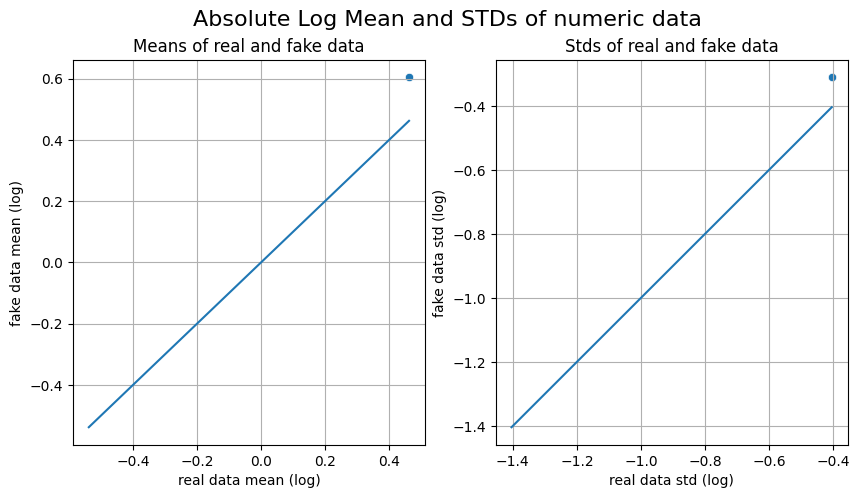

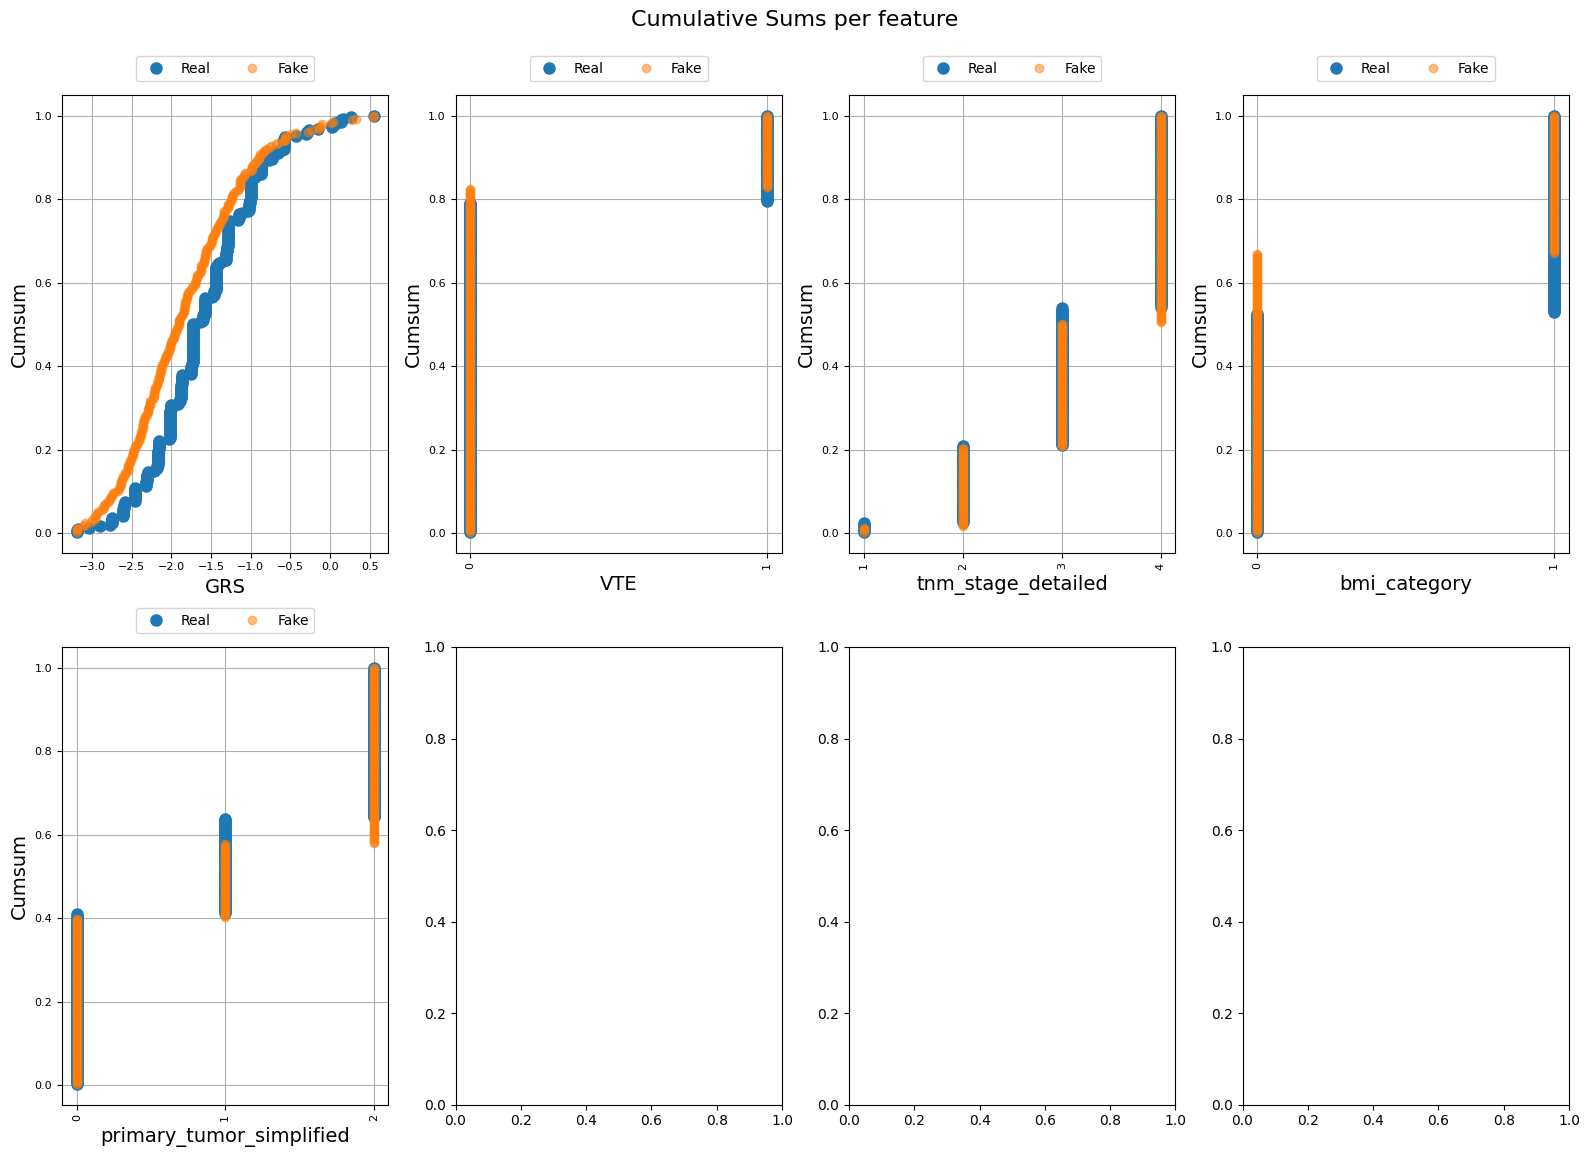

AttributeError: 'Series' object has no attribute 'append'

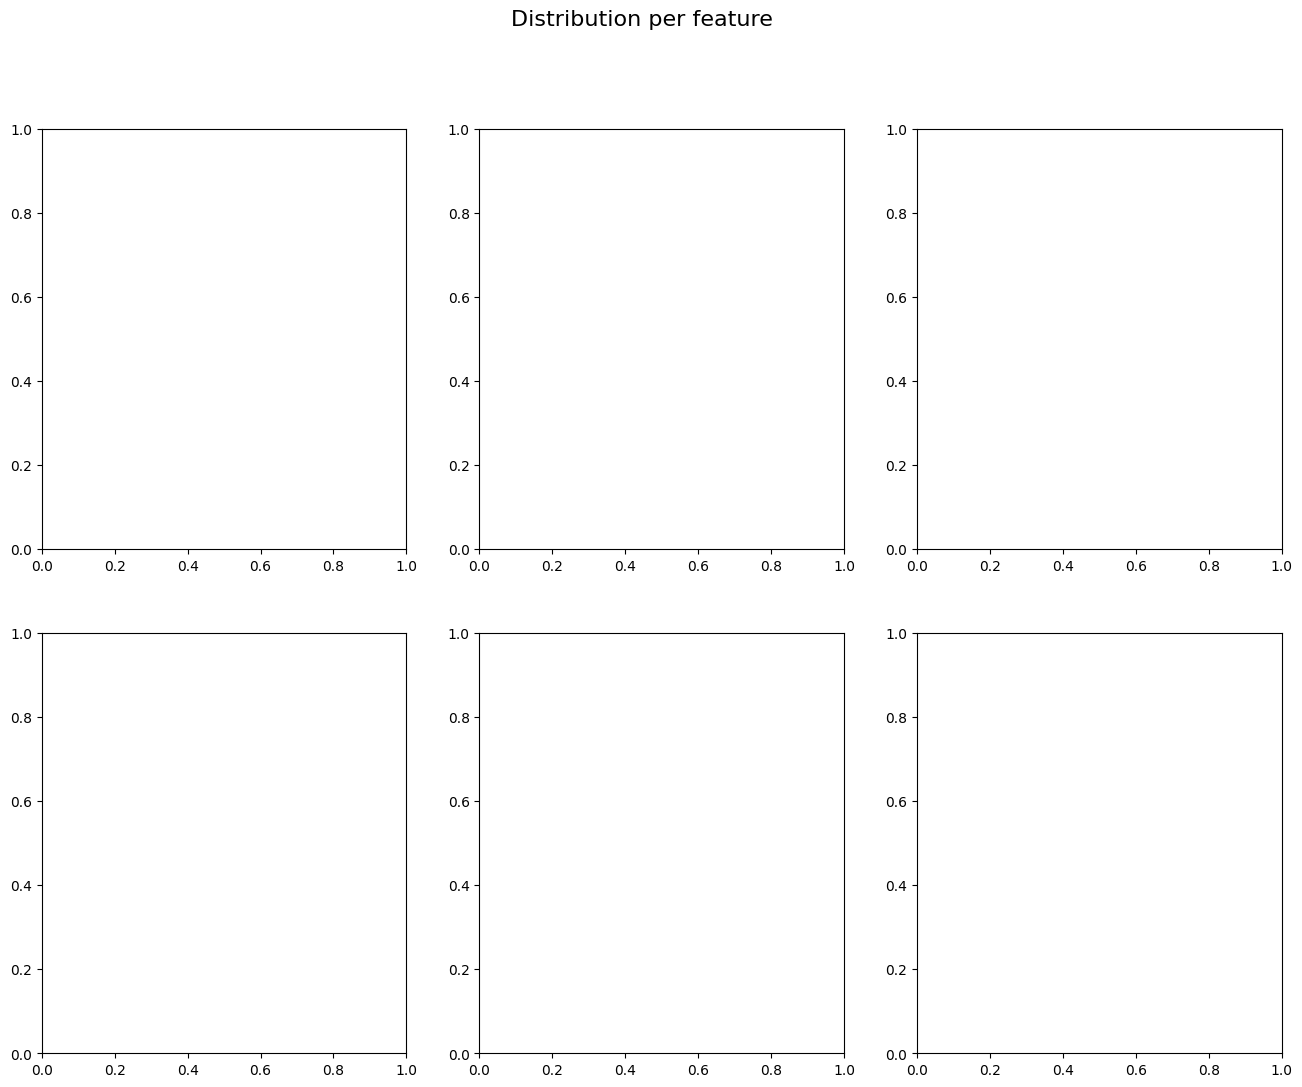

In [28]:
from table_evaluator import TableEvaluator

table_evaluator = TableEvaluator(df_no_dupes, synth_gen, cat_cols = ['bmi_category', 'primary_tumor_simplified', 'VTE', 'tnm_stage_detailed'])
table_evaluator.visual_evaluation()

In [29]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(synth_gen.drop('VTE', axis=1), synth_gen['VTE'], test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.853

In [30]:
y_pred = clf.predict(X_test)
auc_obs = roc_auc_score(y_test, y_pred)
print(auc_obs)

0.5696861742630263


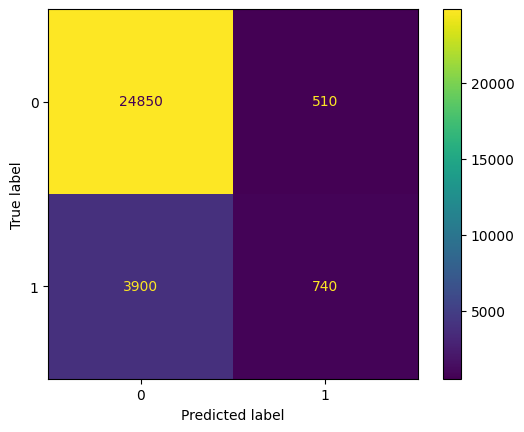

In [31]:
# Compute confusion matrix
cm = confusion_matrix(y_test.values, np.round(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [32]:
#Load data form baselines curves
roc_curve_onco = pd.read_csv('no_dups_roc_curve_oncothromb_score_replicated.csv')
pr_curve_onco = pd.read_csv('no_dups_pr_curve_oncothromb_score_replicated.csv')
roc_curve_orig = pd.read_csv('mean_roc_curve_from_cv_oncothromb.csv')
prc_curve_orig = pd.read_csv('pr_curve_oncothromb_score_replicated.csv')

C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


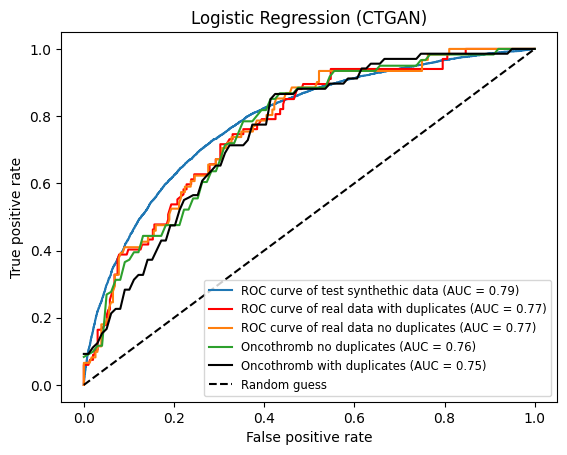

In [33]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
#fpr_2, tpr_2, thresholds_2 = roc_curve(y_points,pred_points)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_real_dupes,clf.predict_proba(X_real_dupes)[:,1])
fpr_4, tpr_4, thresholds_4 = roc_curve(y_real_no_dupes,clf.predict_proba(X_real_no_dupes)[:,1])


# Calculate the AUC value
auc_value = auc(fpr, tpr)
auc_value_2 = auc(fpr_3, tpr_3)
auc_value_5 = auc(fpr_4, tpr_4)
auc_value_3 = auc(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'])
auc_value_4 = auc(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'])


# Plot the ROC curve and add the AUC value to the plot
plt.plot(fpr, tpr, label='ROC curve of test synthethic data (AUC = %0.2f)' % auc_value)
plt.plot(fpr_3, tpr_3, color='red',label='ROC curve of real data with duplicates (AUC = %0.2f)' % auc_value_2)
plt.plot(fpr_4, tpr_4,label='ROC curve of real data no duplicates (AUC = %0.2f)' % auc_value_5)
plt.plot(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'], label='Oncothromb no duplicates (AUC = %0.2f)' % auc_value_3)
plt.plot(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'],color='black', label='Oncothromb with duplicates (AUC = %0.2f)' % auc_value_4)

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression (CTGAN)')
plt.legend(loc='lower right', fontsize='small')
# Save figure with higher DPI
#plt.savefig('ROC_curve_TVAE_new.png', dpi=300)
plt.show()


C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


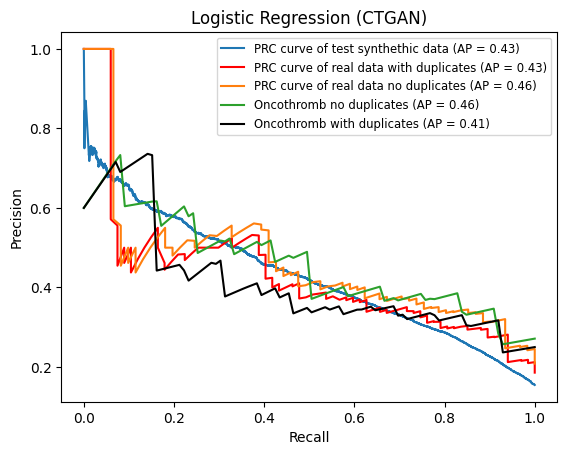

In [34]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, and threshold values for test data
precision2, recall2, threshold2 = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

# Get precision, recall, and threshold values for real data
precision3, recall3, threshold3 = precision_recall_curve(y_real_dupes, clf.predict_proba(X_real_dupes)[:, 1])
precision4, recall4, threshold4 = precision_recall_curve(y_real_no_dupes, clf.predict_proba(X_real_no_dupes)[:, 1])


# Create a new figure and axis object
fig, ax = plt.subplots()

ap = auc(pr_curve_onco.recall_points, pr_curve_onco.mean_precision)
ap_2 = auc(recall2, precision2)
ap_3 = auc(recall3, precision3)
ap_5 = auc(recall4, precision4)
ap_4 = auc(prc_curve_orig.recall, prc_curve_orig.precision)


# Plot the test data Precision-Recall curve
ax.plot(recall2, precision2, label='PRC curve of test synthethic data (AP = %0.2f)' % ap_2)

# Plot the real data Precision-Recall curve
ax.plot(recall3, precision3, color='red', label='PRC curve of real data with duplicates (AP = %0.2f)' % ap_3)
ax.plot(recall4, precision4,  label='PRC curve of real data no duplicates (AP = %0.2f)' % ap_5)


# Plot the synthethic data Precision-Recall curve
ax.plot(pr_curve_onco.recall_points, pr_curve_onco.mean_precision, label='Oncothromb no duplicates (AP = %0.2f)' % ap)

ax.plot(prc_curve_orig.recall, prc_curve_orig.precision,color='black', label='Oncothromb with duplicates (AP = %0.2f)' % ap_4)

# Set the x and y axis labels, title, and legend
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Logistic Regression (CTGAN)")
plt.legend(loc='best', fontsize='small')

# Save the figure and show it
#plt.savefig('PRC_curve_TVAE_new.png', dpi=300)
plt.show()


# Train a Deep Learning Model with Synthethic Data

In [35]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(synth_gen.drop('VTE', axis=1), synth_gen['VTE'], test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def make_model(metrics=METRICS):

    # Define the MLP model with skip connections and dropout
    inputs = keras.layers.Input(shape=(X_train.shape[1],))
    
    x = keras.layers.Dense(units=128, activation='relu')(inputs)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Dense(units=64, activation='relu')(x)
    x = keras.layers.Dropout(0.1)(x)
    
   
    x = keras.layers.Dense(units=16, activation='relu')(x)
    
    outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model with the specified optimizer, loss function, and metrics
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss= keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics)

    return model

In [36]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=8,
    mode='max',
    restore_best_weights=True)

In [37]:
del model

In [38]:
from tensorflow.keras.optimizers.schedules import InverseTimeDecay

model = make_model(metrics=METRICS)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    epochs=EPOCHS,
    validation_data=(X_test, y_test))

Epoch 1/100
3750/3750 [==============================] - 12s 3ms/step - loss: 0.3640 - tp: 2911.0000 - fp: 2097.0000 - tn: 99201.0000 - fn: 15791.0000 - accuracy: 0.8509 - precision: 0.5813 - recall: 0.1557 - auc: 0.7783 - prc: 0.4104 - val_loss: 0.3558 - val_tp: 851.0000 - val_fp: 631.0000 - val_tn: 24729.0000 - val_fn: 3789.0000 - val_accuracy: 0.8527 - val_precision: 0.5742 - val_recall: 0.1834 - val_auc: 0.7902 - val_prc: 0.4290
Epoch 2/100
3750/3750 [==============================] - 9s 2ms/step - loss: 0.3601 - tp: 3041.0000 - fp: 2149.0000 - tn: 99149.0000 - fn: 15661.0000 - accuracy: 0.8516 - precision: 0.5859 - recall: 0.1626 - auc: 0.7844 - prc: 0.4191 - val_loss: 0.3556 - val_tp: 1128.0000 - val_fp: 914.0000 - val_tn: 24446.0000 - val_fn: 3512.0000 - val_accuracy: 0.8525 - val_precision: 0.5524 - val_recall: 0.2431 - val_auc: 0.7912 - val_prc: 0.4298
Epoch 3/100
3750/3750 [==============================] - 10s 3ms/step - loss: 0.3596 - tp: 2951.0000 - fp: 2153.0000 - tn: 991

Epoch 20/100
3750/3750 [==============================] - 10s 3ms/step - loss: 0.3579 - tp: 2896.0000 - fp: 1957.0000 - tn: 99341.0000 - fn: 15806.0000 - accuracy: 0.8520 - precision: 0.5967 - recall: 0.1548 - auc: 0.7883 - prc: 0.4224 - val_loss: 0.3544 - val_tp: 554.0000 - val_fp: 335.0000 - val_tn: 25025.0000 - val_fn: 4086.0000 - val_accuracy: 0.8526 - val_precision: 0.6232 - val_recall: 0.1194 - val_auc: 0.7923 - val_prc: 0.4300
Epoch 21/100
3750/3750 [==============================] - 10s 3ms/step - loss: 0.3580 - tp: 2857.0000 - fp: 1913.0000 - tn: 99385.0000 - fn: 15845.0000 - accuracy: 0.8520 - precision: 0.5990 - recall: 0.1528 - auc: 0.7881 - prc: 0.4233 - val_loss: 0.3538 - val_tp: 730.0000 - val_fp: 495.0000 - val_tn: 24865.0000 - val_fn: 3910.0000 - val_accuracy: 0.8532 - val_precision: 0.5959 - val_recall: 0.1573 - val_auc: 0.7930 - val_prc: 0.4306
Epoch 21: early stopping


10/10 [==============================] - 0s 1ms/step


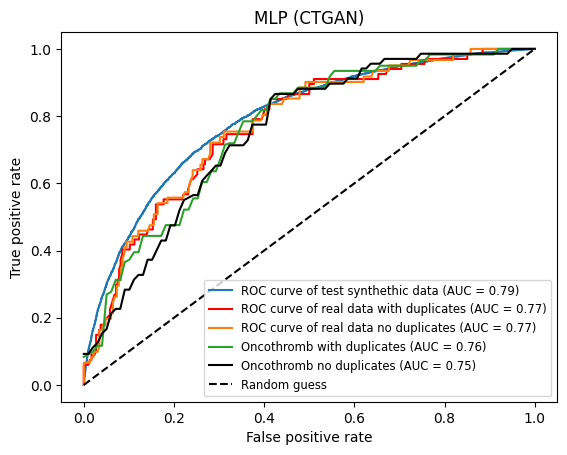

In [39]:
# Calculate the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test,model.predict(X_test))
fpr_3, tpr_3, thresholds_3 = roc_curve(y_real_dupes,model.predict(X_real_dupes))
fpr_4, tpr_4, thresholds_4 = roc_curve(y_real_no_dupes,model.predict(X_real_no_dupes))


# Calculate the AUC value
auc_value = auc(fpr, tpr)
auc_value_2 = auc(fpr_3, tpr_3)
auc_value_5 = auc(fpr_4, tpr_4)
auc_value_3 = auc(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'])
auc_value_4 = auc(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'])


# Plot the ROC curve and add the AUC value to the plot
plt.plot(fpr, tpr, label='ROC curve of test synthethic data (AUC = %0.2f)' % auc_value)
plt.plot(fpr_3, tpr_3,color='red', label='ROC curve of real data with duplicates (AUC = %0.2f)' % auc_value_2)
plt.plot(fpr_4, tpr_4, label='ROC curve of real data no duplicates (AUC = %0.2f)' % auc_value_5)

plt.plot(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'], label='Oncothromb with duplicates (AUC = %0.2f)' % auc_value_3)
plt.plot(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'], color='black',label='Oncothromb no duplicates (AUC = %0.2f)' % auc_value_4)

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('MLP (CTGAN)')
plt.legend(loc='best', fontsize='small')

# Save figure with higher DPI
#plt.savefig('ROC_curve_MLP_copulaGAN.png', dpi=300)
plt.show()

10/10 [==============================] - 0s 2ms/step


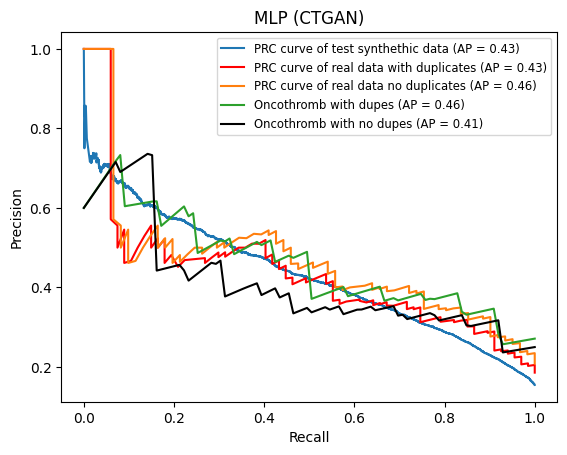

In [40]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, and threshold values for test data
precision2, recall2, threshold2 = precision_recall_curve(y_test, model.predict(X_test))

# Get precision, recall, and threshold values for real data
precision3, recall3, threshold3 = precision_recall_curve(y_real_dupes, model.predict(X_real_dupes))
precision4, recall4, threshold4 = precision_recall_curve(y_real_no_dupes, model.predict(X_real_no_dupes))


# Create a new figure and axis object
fig, ax = plt.subplots()

ap = auc(pr_curve_onco.recall_points, pr_curve_onco.mean_precision)
ap_4 = auc(prc_curve_orig.recall, prc_curve_orig.precision)
ap_2 = auc(recall2, precision2)
ap_3 = auc(recall3, precision3)
ap_5 = auc(recall4, precision4)

# Plot the test data Precision-Recall curve
ax.plot(recall2, precision2, label='PRC curve of test synthethic data (AP = %0.2f)' % ap_2)

# Plot the real data Precision-Recall curve
ax.plot(recall3, precision3, color='red', label='PRC curve of real data with duplicates (AP = %0.2f)' % ap_3)
ax.plot(recall4, precision4, label='PRC curve of real data no duplicates (AP = %0.2f)' % ap_5)


# Plot the synthethic data Precision-Recall curve
ax.plot(pr_curve_onco.recall_points, pr_curve_onco.mean_precision, label='Oncothromb with dupes (AP = %0.2f)' % ap)

ax.plot(prc_curve_orig.recall, prc_curve_orig.precision,color='black', label='Oncothromb with no dupes (AP = %0.2f)' % ap_4)


# Set the x and y axis labels, title, and legend
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("MLP (CTGAN)")
plt.legend(loc='best', fontsize='small')

# Save the figure and show it
# plt.savefig('PRC_curve_MLP_copulaGAN.png', dpi=300)
plt.show()